In [1]:
# Import dependencies
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
import datetime as dt
import time
import requests
import json
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import locale
locale.setlocale(locale.LC_ALL,'')

from config import apikey

# Dependencies for sending dataframes to sql database
from sqlalchemy import create_engine
from sqlConfig import user, password

### *Using Alpha Vantange API - Find Data for SPY (S&P 500)*

In [2]:
data_frequency = 'MONTHLY'
SPY_ticker = 'SPY'

SPY_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_{data_frequency}&symbol={SPY_ticker}&apikey=' + apikey
SPY_response = requests.get(SPY_url).json()

In [3]:
SPY_dates = []
SPY_close = []

for dates in SPY_response['Monthly Time Series']:

        if dates not in SPY_dates:
            
            # Tech market crash in 2001. 
            #To exclude outlier which contributes bias in data, data beginning 2003 (end of downward trend) will be used.
            if dates >= "2003-01-01":
                
                SPY_dates.append(dates)
                SPY_close.append(SPY_response['Monthly Time Series'][dates]['4. close'])


SPY_data = pd.DataFrame({'Date': SPY_dates, 'SPY_Close': SPY_close})
SPY_data            

,Date,SPY_Close
0,2020-01-07,322.7300
1,2019-12-31,321.8600
2,2019-11-29,314.3100
3,2019-10-31,303.3300
4,2019-09-30,296.7700
...,...,...
200,2003-05-30,96.9500
201,2003-04-30,91.9100
202,2003-03-31,84.7400
203,2003-02-28,84.9000


### *Using Alpha Vantange API - Find data for VBMFX (Total Bond)*

In [5]:
VBMFX_ticker = 'VBMFX'

VBMFX_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_{data_frequency}&symbol={VBMFX_ticker}&apikey=' + apikey
VBMFX_response = requests.get(VBMFX_url).json()

In [6]:
VBMFX_dates = []
VBMFX_close = []

for dates in VBMFX_response['Monthly Time Series']:

        if dates not in VBMFX_dates:
            if dates >= "2003-01-01":
                VBMFX_dates.append(dates)
                VBMFX_close.append(VBMFX_response['Monthly Time Series'][dates]['4. close'])


VBMFX_data = pd.DataFrame({'Date': VBMFX_dates, 'VBMFX_Close': VBMFX_close})
VBMFX_data

,Date,VBMFX_Close
0,2020-01-06,11.1100
1,2019-12-31,11.0500
2,2019-11-29,11.0900
3,2019-10-31,11.1200
4,2019-09-30,11.1200
...,...,...
200,2003-05-30,10.5800
201,2003-04-30,10.4300
202,2003-03-31,10.3800
203,2003-02-28,10.4400


### *Merge SPY and VBMFX DataFrames*

In [7]:
data = SPY_data.merge(VBMFX_data, on='Date')

# Change all column dtypes to datetime or float as appropriate
data['Date'] = pd.to_datetime(data['Date'])
data['SPY_Close'] = pd.to_numeric(data['SPY_Close'])
data['VBMFX_Close'] = pd.to_numeric(data['VBMFX_Close'])

data = data.set_index('Date')

data.dtypes

SPY_Close      float64
VBMFX_Close    float64
dtype: object

In [8]:
# Sort date from high to low so the 12M calculation can be performed properly
data = pd.DataFrame.sort_index(data, ascending=True);

data

,SPY_Close,VBMFX_Close
Date,,
2003-01-31,86.0600,10.34
2003-02-28,84.9000,10.44
2003-03-31,84.7400,10.38
2003-04-30,91.9100,10.43
2003-05-30,96.9500,10.58
...,...,...
2019-08-30,292.4527,11.21
2019-09-30,296.7700,11.12
2019-10-31,303.3300,11.12


### *Calculate 12-Month Percentage Change*

In [9]:
data_12M_Return = data.pct_change(12)
data_12M_Return = data_12M_Return.dropna()

# Update columns to appropriate names
data_12M_Return = data_12M_Return.rename(columns={'Date' : 'Date', 'SPY_Close': 'SPY_Return','VBMFX_Close': 'VBMFX_Return'})

data_12M_Return

,SPY_Return,VBMFX_Return
Date,,
2004-01-30,0.318615,0.001934
2004-02-27,0.354770,-0.000958
2004-03-31,0.334671,0.007707
2004-04-30,0.207268,-0.026846
2004-05-28,0.164105,-0.048204
...,...,...
2019-08-30,0.007381,0.073755
2019-09-30,0.020810,0.073359
2019-10-31,0.120829,0.083821


### *Calculate 12-Month Rolling Returns for Five New Portfolios*

#### The weight for the portfolios are:
    * Very Aggressive: 100% Stock (SPY)
    * Aggeressive: 80% SPY and 20% Bonds (VBMFX)
    * Moderate: 50% SPY and 50% VBMFX
    * Conservative: 20% SPY and 80% VBMFX
    * Very Conservative: 100% VBMFX

In [10]:
data_12M_Return['Very_Aggressive'] = data_12M_Return.SPY_Return

data_12M_Return['Aggressive'] = .8*data_12M_Return.SPY_Return + .2* data_12M_Return.VBMFX_Return

data_12M_Return['Moderate'] = .5*data_12M_Return.SPY_Return + .5* data_12M_Return.VBMFX_Return

data_12M_Return['Conservative'] = .2*data_12M_Return.SPY_Return + .8* data_12M_Return.VBMFX_Return

data_12M_Return['Very_Conservative'] =  data_12M_Return.VBMFX_Return

data_12M_Return

,SPY_Return,VBMFX_Return,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
Date,,,,,,,
2004-01-30,0.318615,0.001934,0.318615,0.255279,0.160275,0.065270,0.001934
2004-02-27,0.354770,-0.000958,0.354770,0.283625,0.176906,0.070188,-0.000958
2004-03-31,0.334671,0.007707,0.334671,0.269278,0.171189,0.073100,0.007707
2004-04-30,0.207268,-0.026846,0.207268,0.160445,0.090211,0.019977,-0.026846
2004-05-28,0.164105,-0.048204,0.164105,0.121643,0.057951,-0.005742,-0.048204
...,...,...,...,...,...,...,...
2019-08-30,0.007381,0.073755,0.007381,0.020656,0.040568,0.060480,0.073755
2019-09-30,0.020810,0.073359,0.020810,0.031320,0.047085,0.062849,0.073359
2019-10-31,0.120829,0.083821,0.120829,0.113427,0.102325,0.091222,0.083821


In [11]:
# Drop unnecessary columns
data_12M_Return = data_12M_Return.drop(columns=['SPY_Return', 'VBMFX_Return'])

data_12M_Return

,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
Date,,,,,
2004-01-30,0.318615,0.255279,0.160275,0.065270,0.001934
2004-02-27,0.354770,0.283625,0.176906,0.070188,-0.000958
2004-03-31,0.334671,0.269278,0.171189,0.073100,0.007707
2004-04-30,0.207268,0.160445,0.090211,0.019977,-0.026846
2004-05-28,0.164105,0.121643,0.057951,-0.005742,-0.048204
...,...,...,...,...,...
2019-08-30,0.007381,0.020656,0.040568,0.060480,0.073755
2019-09-30,0.020810,0.031320,0.047085,0.062849,0.073359
2019-10-31,0.120829,0.113427,0.102325,0.091222,0.083821


### *Create Summary Statics for the Five Portfolios*

Mean, STD and Max will be used for the model calculations

In [12]:
data_summary = data_12M_Return.describe()

data_summary

,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
count,192.000000,192.000000,192.000000,192.000000,192.000000
mean,0.083490,0.067506,0.043530,0.019554,0.003570
std,0.147658,0.118420,0.075651,0.038279,0.029540
min,-0.447541,-0.363486,-0.237403,-0.111319,-0.056200
25%,0.031594,0.030721,0.019771,-0.000007,-0.019016
50%,0.109241,0.088634,0.053453,0.021531,0.003810
75%,0.155522,0.122171,0.080124,0.042480,0.021414
max,0.497903,0.407932,0.272976,0.138019,0.090814


In [13]:
# Drop unnecessary rows
data_summary = data_summary.drop(['count', 'min', '25%', '50%', '75%'])

data_summary

,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
mean,0.083490,0.067506,0.043530,0.019554,0.003570
std,0.147658,0.118420,0.075651,0.038279,0.029540
max,0.497903,0.407932,0.272976,0.138019,0.090814


### *Send DataFrames to PostgreSQL*

In [14]:
# Prepare to send dataframe to postgresSQL database. Create connection
rds_connection_string = user + ":" + password + "@localhost:5432/investmentDB"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [15]:
# Check for tables
engine.table_names()

[]

In [16]:
# Send the 12M dataframe to postgreSQL
data_12M_Return.to_sql(name='12M_Return', con=engine, if_exists='append', index=True)

In [17]:
# Send the Summary dataframe to postgreSQL
data_summary.to_sql(name='data_summary', con=engine, if_exists='append', index=True)

In [18]:
# Check for tables
engine.table_names()

['12M_Return', 'data_summary']

### *Below Calculates the Ending Portfolio Value Based on:*
    * Initial investment (pv)
    * Additions
    * Time horizon
    * Expected rate of returns
##### This will NOT be used as the market returns are never uniform

In [19]:
pv = 10000
additions = 10000
time_horizon = 30
expected_return = 0.0867

print("\tReturn", "\t\tEnding Value".rjust(18))
for year in range(time_horizon):
    market_return = np.random.normal(expected_return)
    ending = pv * (1 + expected_return) + additions
    print("\t{}".ljust(10).format(round(market_return,4)), "\t{}".rjust(10).format(locale.currency(ending, grouping=True)))
    pv = ending

	Return     		Ending Value
	0.084               	$20,867.00
	-0.5033               	$32,676.17
	-0.6463               	$45,509.19
	0.5278               	$59,454.84
	-0.6506               	$74,609.57
	-0.168               	$91,078.22
	0.1439               	$108,974.71
	-1.2009               	$128,422.81
	-0.1598               	$149,557.07
	0.578               	$172,523.67
	0.6946               	$197,481.47
	-0.0475               	$224,603.12
	-0.0047               	$254,076.21
	0.1098               	$286,104.61
	2.6533               	$320,909.88
	0.5651               	$358,732.77
	-0.6304               	$399,834.90
	-0.3216               	$444,500.59
	0.0357               	$493,038.79
	-0.5478               	$545,785.25
	0.2563               	$603,104.83
	-0.3455               	$665,394.02
	0.2517               	$733,083.68
	-0.2198               	$806,642.04
	0.4146               	$886,577.90
	0.0741               	$973,444.21
	-0.1652               	$1,067,841.82
	-0.326              

### *Below Calculates the Ending Portfolio Value Based on:*
    * Initial investment (pv)
    * Additions
    * Time horizon
    * Expected rate of returns
    * AND Standard Deviation
##### These calculations are more likely to happen, but multiple simulations will be performed

In [20]:
pv = 10000
annual_addition = 10000
time_horizon = 30
expected_return = 0.0867
volatility = 0.17


print("\tReturn", "\t\tEnding Value".rjust(18))
for year in range(time_horizon):
    market_return = np.random.normal(expected_return, volatility)
    fv = pv * (1 + market_return) + annual_addition
    print("\t{}".ljust(10).format(round(market_return,4)), "\t{}".rjust(10).format(locale.currency(fv, grouping=True)))
    pv = fv

	Return     		Ending Value
	0.403               	$24,030.17
	0.2708               	$40,537.39
	0.0555               	$52,787.82
	0.2414               	$75,532.57
	0.1526               	$97,055.80
	0.2773               	$133,966.43
	0.3831               	$195,290.16
	0.1163               	$228,001.80
	0.3449               	$316,635.62
	0.4735               	$476,565.14
	0.2169               	$589,954.74
	0.2047               	$720,743.36
	0.1111               	$810,851.12
	0.2433               	$1,018,163.20
	-0.0466               	$980,685.52
	0.2368               	$1,222,904.39
	-0.1943               	$995,308.66
	0.1199               	$1,124,625.66
	0.1451               	$1,297,859.31
	0.0464               	$1,368,138.77
	-0.0679               	$1,285,224.07
	0.2104               	$1,565,591.61
	0.0382               	$1,635,402.72
	0.3384               	$2,198,864.76
	0.0535               	$2,326,531.68
	0.1758               	$2,745,453.56
	-0.0672               	$2,570,846.41
	0.270

#### *For the web app version, PV, annual_investment and time_horizon will be grabbed from user input.*
#### *Expected_return and volatility will be grabbed from the portfolio selected.*

In [21]:
sim = pd.DataFrame()
iterations = 100

for x in range(iterations):
    
    expected_return = .0867 #Value based on selection
    volatility = .17 #Value based on selection
    time_horizon = 30 #Input Value
    pv = 10000 #Input Value
    annual_investment = 10000 #Input Value
    stream = []
    
    for i in range(time_horizon):
        
        end = round(pv * (1 + np.random.normal(expected_return,volatility)) + annual_investment,2)
        
        stream.append(end)

        pv = end

    
    sim[x] = stream

In [22]:
first_ten = list(range(10))
sim[first_ten]

,0,1,2,3,4,5,6,7,8,9
0,21661.27,19480.64,20085.73,19734.28,21511.91,22322.90,20593.36,23473.78,21653.04,19133.70
1,33785.37,36176.50,33859.31,28616.81,29642.37,32946.48,34714.38,39523.78,36788.92,33787.57
2,38094.17,41169.67,48874.76,43769.34,43007.39,49844.84,44433.56,55160.49,41024.36,44369.85
3,40883.07,66372.67,73490.16,65732.42,59367.97,59577.83,64268.47,54455.38,49110.54,56837.31
4,54472.00,85398.42,100134.09,91860.17,81865.73,80288.09,84479.37,75491.37,59493.94,61087.29
5,59087.58,99818.08,100869.08,98520.05,102090.56,101817.16,120420.51,101557.27,56172.11,77729.38
6,63259.70,121468.50,123406.57,139768.62,129205.75,114715.12,152994.00,110586.97,64556.90,95905.59
7,79831.58,149751.87,137462.79,182370.77,139119.85,121705.51,197274.14,104438.50,73307.64,111614.93
8,103056.51,139072.05,158974.70,253705.71,164407.11,138104.38,159090.58,125481.44,94828.19,134843.75
9,126551.25,180508.83,174010.21,299460.55,149399.27,128705.51,200742.87,182154.09,111644.28,132373.90


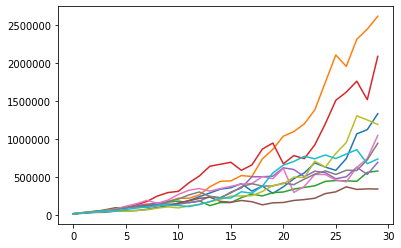

In [23]:
plt.plot(sim[first_ten])
plt.show()

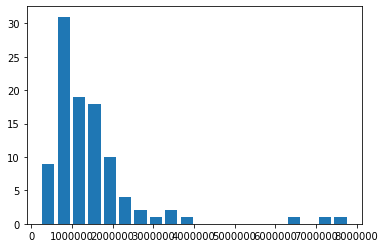

In [24]:
#Sim index values based on 30-1 years to account for Zero Index
ending_values = sim.loc[29]

plt.hist(ending_values, bins=20, rwidth=0.8)
plt.show()

In [25]:
p_tiles = np.percentile(ending_values,[5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95])

for p in range(len(p_tiles)):
    
    l = [5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95]
    print( "{}%-ile: ".format(l[p]).rjust(15),"{}".format(locale.currency(p_tiles[p], grouping=True)))

       5%-ile:  $477,591.28
      10%-ile:  $662,278.22
      15%-ile:  $715,159.88
      20%-ile:  $748,487.65
      25%-ile:  $801,913.24
      50%-ile:  $1,194,969.97
      75%-ile:  $1,631,858.68
      80%-ile:  $1,792,487.86
      85%-ile:  $1,931,104.55
      90%-ile:  $2,326,648.39
      95%-ile:  $3,279,305.31


In [26]:
# Calculate success rate

prob_of_success = len(ending_values[ending_values>4000000]) / len(ending_values)

f"The rate of success is {prob_of_success*100} %"

'The rate of success is 3.0 %'